# CNN: the Basics

A convolutional neural network (CNN) is a deep-learning algorithm frequently used for analysing image data. In this notebook, we will learn the basics of a CNN and apply it to classify the `fashion-mnist` dataset.


In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import skimage
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.0


---

# Convolutional Filter

A convolutional filter is the basic element (or neuron) of a CNN. To better understand CNN, we first learn how a convolutional filter works by hand coding it.

### The kernel

A convolutional filter extracts a part of the input image and inner-product it with a **kernel** to fill one pixel in the output image. The process is illustrated in the following figure. The behaviour of a convolutional filter is predominated by its kernel. *For image processing, we need to specify the kernel as an input parameter. In a CNN, however, we only specify the size of the kernels whereas their values are learnt by training.*

<img src="https://i.ibb.co/KGmm8rt/conv3x3.png" width="80%">

### Padding and stride

In addition to the kernel, there are some other useful parameters, such as:

* **Padding**: padding zeros around the input image to preserve (or even increase) the image size, e.g., when padding = 1:

<img src="https://i.ibb.co/84FMN2v/padding.png" width="90%">

* **Stride**: it controls how fast the kernel moves over the input image and thus the size of the output image, e.g., when stride = 2:

<img src="https://i.ibb.co/hKByCnh/strides.png" width="50%">

### Implement a convolutional filter
#### Input
* `input_image`: an input image with shape (nx, ny, nchannel)
* `kernel`: a square matrix with shape (k, k)
* `padding`: a non-negative integer
* `stride`: a positive integer; to sample the right edge of the input image, it must divide (nx + padding * 2 - k), similarly for the bottom edge; it also controls the output resolution and the computational cost

#### Output
* `return`: an output image with shape (nx_out, ny_out, nchannel), where nx_out = (nx + padding * 2 - k) // stride + 1 and ny_out = (ny + padding * 2 - k) // stride + 1

**NOTE**: For readability, the code is a dry implementation without much optimisation, so its performance is not high. Increase `stride` to speedup the processing at the cost of a downsampled output image.

In [2]:
# a 2D convolutonal filter
def convolve2D(input_image, kernel, padding=1, stride=1):
    # padding
    nx = input_image.shape[0]
    ny = input_image.shape[1]
    nchannel = input_image.shape[2]
    if padding > 0:
        padded_image = np.zeros((nx + padding * 2, ny + padding * 2, nchannel))
        padded_image[padding:-padding, padding:-padding, :] = input_image
    else:
        padded_image = input_image
    
    # allocate output
    k = kernel.shape[0]
    nx_out = (nx + padding * 2 - k) // stride + 1 # must use // instead of /
    ny_out = (ny + padding * 2 - k) // stride + 1
    output_image = np.zeros((nx_out, ny_out, nchannel))
    
    # compute output pixel by pixel
    for ix_out in np.arange(nx_out):
        for iy_out in np.arange(ny_out):
            ix_in = ix_out * stride
            iy_in = iy_out * stride
            # the inner product
            output_image[ix_out, iy_out, :] = \
            np.tensordot(kernel, padded_image[ix_in:(ix_in + k), iy_in:(iy_in + k), :], axes=2)
    
    # truncate to [0, 1]
    output_image = np.maximum(output_image, 0)
    output_image = np.minimum(output_image, 1)
    return output_image

### Apply our convolutional filter

Next, we load an image from `skimage.data` and apply our convolutional filter to it. Here we will use the 3$\times$3 Sobel kernel, which is good at edge detection:

>$k=\begin{bmatrix}
  1 & 0 & -1\\ 
  2 & 0 & -2\\
  1 & 0 & -1
\end{bmatrix}$ 

In [3]:
# load some image
input_image = skimage.data.coffee()
input_image = input_image / 255.

# print image size
print('Image pixels: %d x %d' % (input_image.shape[0], input_image.shape[1]))
print('Channels (RGB): %d' % (input_image.shape[2]))

Image pixels: 400 x 600
Channels (RGB): 3


In [4]:
# vertical Sobel kernel
kernel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

##################################
# Also try the following kernels #
##################################

# # horizontal Sobel kernel
# kernel = np.array([
#     [1, 2, 1],
#     [0, 0, 0],
#     [-1, -2, -1]])

# # smoothening
# kernel = np.array([
#     [1, 1, 1],
#     [1, 1, 1],
#     [1, 1, 1]]) / 9

# # sharpening
# kernel = np.array([
#     [0, -1, 0],
#     [-1, 5, -1],
#     [0, -1, 0]])


#######################
# Try a larger stride #
#######################
# do convolution
output_image = convolve2D(input_image, kernel, padding=1, stride=1)

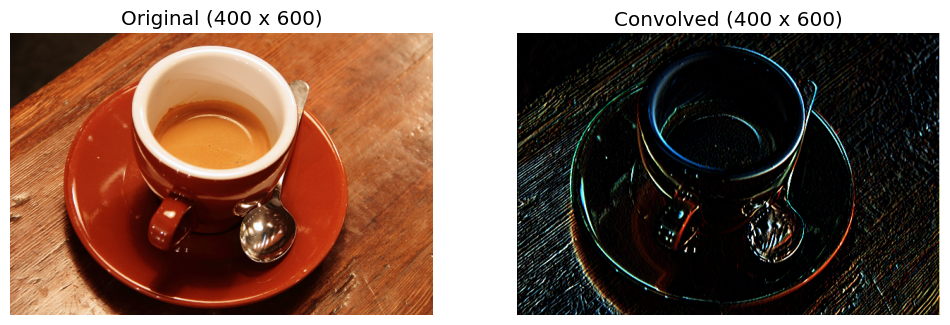

In [5]:
# plot original image
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title('Original (%d x %d)' % (input_image.shape[0], input_image.shape[1]))

# plot convolved image
plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.axis('off')
plt.title('Convolved (%d x %d)' % (output_image.shape[0], output_image.shape[1]))
plt.show()

The above results show that the Sobel kernel can depict the outline of the objects. The capability of detecting object features by associating neighboring pixels makes CNNs powerful in analysing image data.


### Exercise

The vertical and the horizontal Sobel kernels can be superposed to make an inclined-edge detecting kernel:

>$k(\theta)=\cos(\theta)\begin{bmatrix}
  1 & 2 & 1\\ 
  0 & 0 & 0\\
  -1 & -2 & -1
\end{bmatrix}
+
\sin(\theta)\begin{bmatrix}
  1 & 0 & -1\\ 
  2 & 0 & -2\\
  1 & 0 & -1
\end{bmatrix},
$
> where $\theta$ is the angle from horizontal.

Find a kernel to erase most of the stripes on the table.

---

# CNN for `fashion-mnist`

Now we train a CNN to classify the `fashion-mnist` dataset, following the same steps elaborated in [03_DNN_basics.ipynb](03_DNN_basics.ipynb). 

## 0. Load the dataset

As before, we start by loading the dataset. Note that we are appending a channel dimension to the images as required by the convolutional layers.

In [6]:
# load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# append a channel dimension as required by Conv2D
train_images = np.array([train_images]).transpose([1, 2, 3, 0])
test_images = np.array([test_images]).transpose([1, 2, 3, 0])

# string labels
string_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0, :, :, 0].shape))
print("Number of channels: %s" % str(train_images.shape[-1]))

Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of channels: 1


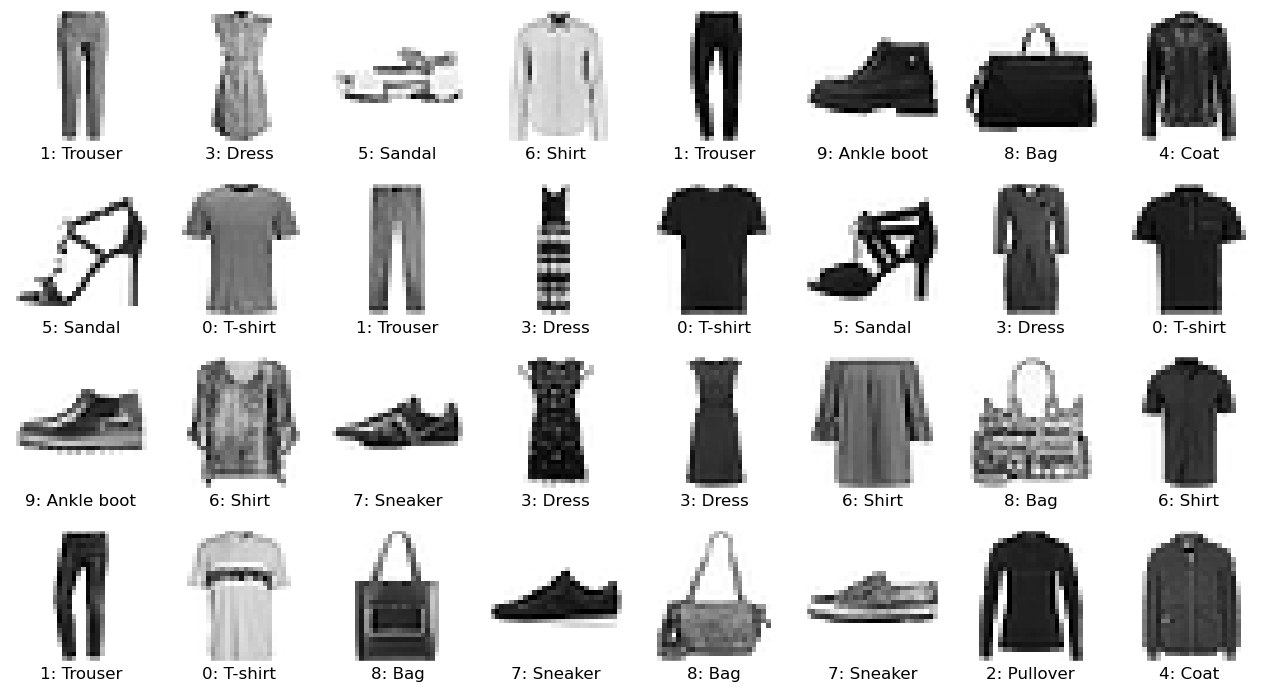

In [7]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(np.squeeze(image), cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

## 1. Build the network architecture

Our CNN contains two convolutional layers, each followed by a max-pooling layer and a batch-normalisation layer, and then a dense layer with dropout and finally the output layer. The network architecture is shown in the following figure ([figure source](https://mc.ai/the-convolution-parameters-calculation/)):

![layer.jpeg](https://i.ibb.co/VDJ301m/layer.jpg)


We have understood how a convolutional filter works. A convolutional layer is simply a collection of convolutional filters whose kernel values form the trainable parameters. The most frequently used kernel sizes are 3$\times$3, 5$\times$5 and 7$\times$7. The number of filters in each layer is a key network parameter governing the model size. 

The *max-pooling* layers are aimed for dimensionality reduction, containing no trainable parameters. It can be easily understood with the following illustration ([figure source](https://medium.com/ai-in-plain-english/pooling-layer-beginner-to-intermediate-fa0dbdce80eb)). The most common size for max pooling is 2$\times$2.

<img src="https://i.ibb.co/fM1Qbc2/maxpooling.png" width="50%">

The *batch-normalisation* layers can help the CNN to converge faster and become more stable through normalisation of the input layer by re-centering and re-scaling.

In [8]:
# build the network architecture
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

## 2. Compile the model

In [9]:
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## 3. Train the model

In [10]:
# train the model
training_history = model.fit(train_images, train_labels, epochs=10, batch_size=32, 
                             validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.5346 - accuracy: 0.8091 - val_loss: 0.3615 - val_accuracy: 0.8693
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3446 - accuracy: 0.8753 - val_loss: 0.3004 - val_accuracy: 0.8909
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.2996 - accuracy: 0.8912 - val_loss: 0.2874 - val_accuracy: 0.8984
Epoch 4/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2771 - accuracy: 0.8999 - val_loss: 0.2829 - val_accuracy: 0.8980
Epoch 5/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.2608 - accuracy: 0.9032 - val_loss: 0.2832 - val_accuracy: 0.9016
Epoch 6/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2447 - accuracy: 0.9100 - val_loss: 0.3000 - val_accuracy: 0.8948
Epoch 7/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.2336 - accuracy: 0.9144 - val_loss: 0.2834 -

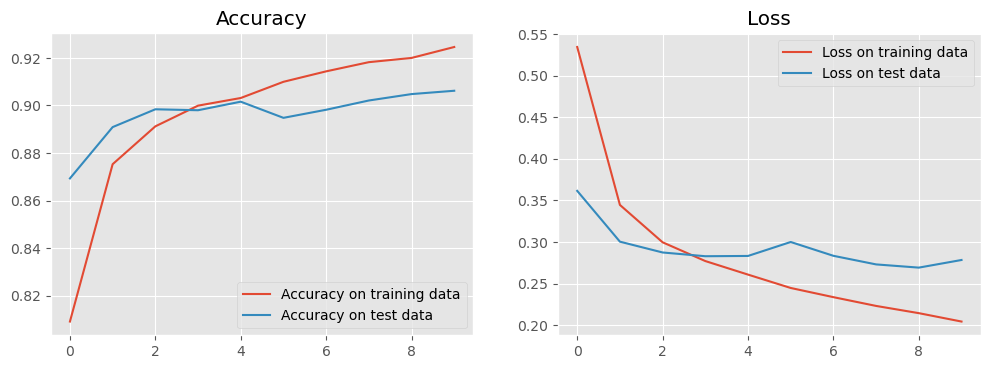

In [11]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

Compared to our fully connected DNN in [03_DNN_basics.ipynb](03_DNN_basics.ipynb), our CNN turns out more efficient. It can achieve a higher accuracy with much fewer epochs.

## 4. Make predictions

In [12]:
# use test images to predict
pred_lables = model.predict(test_images).argmax(axis=1)

Number of test data: 10000
Number of wrong predictions: 938


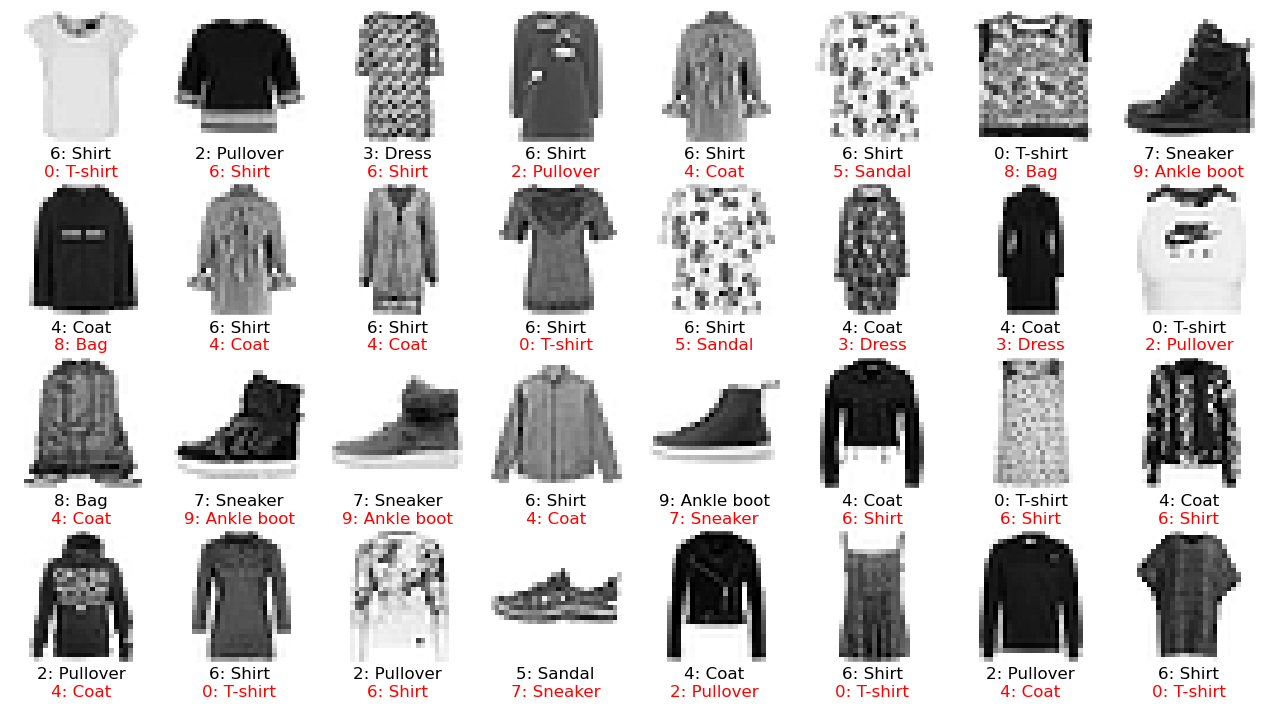

In [13]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

## Exercises

Classify a more complicated dataset, e.g., a randomly rotated `fashion-mnist` as shown below. For the augmented dataset, compare the accuracy of a CNN and a fully connected DNN.  

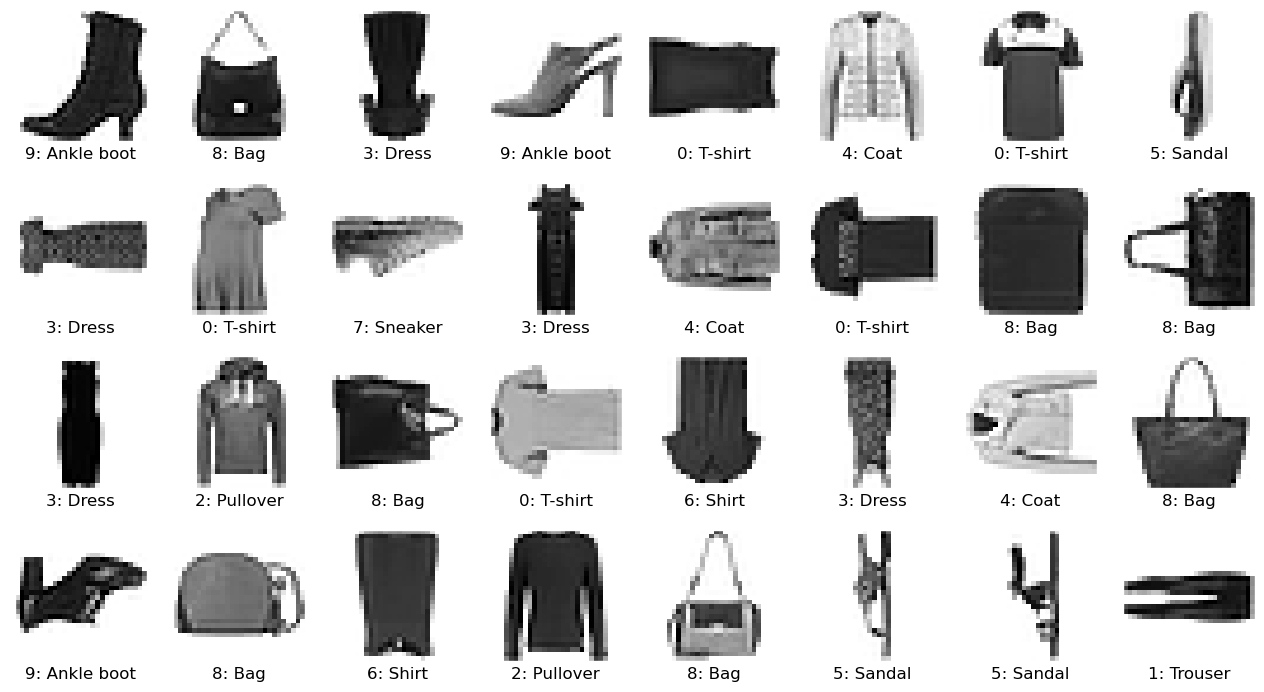

In [14]:
# rotate images randomly by k * 90 degrees
# train
train_images_rot = train_images.copy()
for i in np.arange(train_images.shape[0]):
    train_images_rot[i] = np.rot90(train_images[i], k=np.random.choice([0, 1, 2, 3]))
    
# test
test_images_rot = test_images.copy()
for i in np.arange(test_images.shape[0]):
    test_images_rot[i] = np.rot90(test_images[i], k=np.random.choice([0, 1, 2, 3]))
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images_rot[idata], label, nrows, ncols, iplot)
plt.show()